In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve

# Cvičení 12-13: Řešení (soustav) ODR

---
- [poznámky z přednášky - jednokrokové metody 1](https://www.karlin.mff.cuni.cz/~kucera/ZNM/9%20-%20Numericke%20reseni%20ODR.pdf)
- [poznámky z přednášky - jednokrokové metody 2](https://www.karlin.mff.cuni.cz/~kucera/ZNM/10%20-%20Jednokrokove%20metody.pdf)
- Extra materiály
  - kniha [Trefethen, Birkisson, Driscoll: Exploring ODEs](https://people.maths.ox.ac.uk/trefethen/Exploring.pdf)  
  - skripta [Dolejší: Fundamentals of Numerical Mathematics](https://www.karlin.mff.cuni.cz/~dolejsi/Vyuka/ZNM.pdf) (Kapitola 6)
  - skripta [Foundations of Applied Mathematics](https://foundations-of-applied-mathematics.github.io/) (Volume 4, Kapitola 2, 3, 4 a 5)

- ***Primární úlohy*** : A2, A3, B2, C1

- ***Úlohy k bonusové části zkoušky*** : A3, C3

- základní ***Learning outcomes*** (cviko, nikoliv přednáška)
  - Umím definovat globální chybu numerického aproximace řešení systému ODR na základě jejího grafu (coby funkce počtu bodů) stanovit řád této aproximace.
  - Umím určit zda je numerická metoda pro řešení (systému) ODR explicitní nebo implicitní.
  - Umím jmenovat a následně porovnat některé explicitní a implicitní numerické metody pro řešení (systému) ODR.
---

## Intro

Budeme se koukat na soustavy obzčejných diferenciálních rovnic (ODR) prvního řádu, tj. na problém

$$
\begin{bmatrix} y_1'(t) \\ \vdots \\ y_d'(t) \end{bmatrix} =
\begin{bmatrix} f_1(y_1(t),\dotsc, y_d(t),t) \\ \vdots \\ f_d(y_1(t),\dotsc, y_d(t),t) \end{bmatrix}
\;\, \mathrm{pro} \; t\in(t_0,T)
\qquad \& \qquad
\begin{bmatrix} y_1(t_0) \\ \vdots \\ y_d(t_0) \end{bmatrix} =
\begin{bmatrix} y^{(0)}_1 \\ \vdots \\ y^{(0)}_d \end{bmatrix}.
$$

Všimněmě si, že místo proměnou naší hledané funkce značíme jako $t$ (narozdíl od přednášky a od kurzů analýzy) - má to několik důvodů a [Michal (cvičící)](https://www.karlin.mff.cuni.cz/~blechta/znm/) vám je všechny rád objasní.

Naši soustavu ODR můžeme tedy zapsat jako

$$
\mathbf{y}'(t) = \mathbf{f}(\mathbf{y}(t),t)
\quad \mathrm{a} \quad
\mathbf{y}(t_0) = \mathbf{y}^{(0)}
$$

Otázky typu "Kdy řešení existuje?", "Jakou má spojitost/hladkost?" nebo "Lze řešení spočítat (nebo o něm něco říci) s tužkou a gumou?" jsou důležité a snažili jste se na ně odpovědět v jednom z kurzů matematické analýzy. My se chceme zabývat problémy z pohledu numerické matematiky, tj. aproximovat řešení $\mathbf{y}(t)$ a bude nás zajímat přesnost, stabilita a podmíněnost tohoto problému/procesu.

Budeme pracovat s tzv. *jednokrokovými metodami*, tj. s metodami, které pro daný krok $h>0$ a hodnotu $\mathbf{y}^{(0)}$ spočítají aproximaci

$$\mathbf{y}^{(1)} \approx \mathbf{y}(t_0 + h)$$

(závorka nad $\mathbf{y}$ neodpovídá derivaci funkce, jak jsme na to zvyklí z analýzy, ale slouží pouze jako "číslovač"). Obecnou jednokrokovou metodu budeme "značit" následujícím způsobem

$$ \mathbf{y}^{(1)} = \mathbf{y}^{(0)} + h \cdot \mathbf{\Phi}(t_0,\mathbf{y}^{(0)},h), $$

kde funkce $\mathbf{\Phi}(t_0,\mathbf{y}^{(0)},h) \, : \, \mathbb{R}\times \mathbb{R}^{d} \times \mathbb{R} \rightarrow \mathbb{R}^{d}$ nám určuje "směr", kterým se vydáme o náš krok $h$ z bodu $(t_0,\mathbf{y}^{(0)})$.

Opakovaným používáním jednokrokové metody můžeme získat aproximaci i vzdálenější "budoucnosti".  Abychom si dále zjednodušili život, budeme psát $t_n := t_0 + n\cdot h$ a dostaneme

$$\mathbf{y}^{(2)} := \mathbf{y}^{(1)} + h\cdot \mathbf{\Phi} \left( t_1,\mathbf{y}^{(1)},h \right) \equiv
\mathbf{y}^{(0)} + h \cdot \mathbf{\Phi}(t_0,\mathbf{y}^{(0)},h) + h\cdot \mathbf{\Phi} \left( t_0+h,\mathbf{y}^{(0)} + h \cdot \mathbf{\Phi}(t_0,\mathbf{y}^{(0)},h),h \right)$$

a tak dále, dokud chceme dále postupovat. Obecně tedy máme

$$\mathbf{y}(t_2) \approx \mathbf{y}^{(2)} =  \mathbf{y}^{(1)} + h\cdot \mathbf{\Phi} \left( t_1,\mathbf{y}^{(1)},h \right), \\
\mathbf{y}(t_3) \approx \mathbf{y}^{(3)} =  \mathbf{y}^{(2)} + h\cdot \mathbf{\Phi} \left( t_2,\mathbf{y}^{(2)},h \right), \\ \vdots \\
\mathbf{y}(t_n) \approx \mathbf{y}^{(n)} =  \mathbf{y}^{(n-1)} + h\cdot \mathbf{\Phi} \left( t_{n-1},\mathbf{y}^{(n-1)},h \right), \\ \vdots \\
\mathbf{y}(t_N) \approx \mathbf{y}^{(N)} =  \mathbf{y}^{(N-1)} + h\cdot \mathbf{\Phi} \left( t_{N-1},\mathbf{y}^{(N-1)},h \right),
$$

kde $T = t_N = N\cdot h$ je poslední bod, ve kterém nás zajímá aproximace řešení $\mathbf{y}(t)$.

> Zjevně
> - tímto procesem bude docházet k akumulaci a propagaci chyb a čím menší krok $h$ tím větší toto může být problém (protože potřebujeme více kroků než se dostaneme k nějakému času $T$, který nás zajímá),
> - pokud zvolíme $h$ příliš veliké, tak můžeme "prošvihnout" důležité události/fenomény, které vykazuje přesné řešení, protože je prostě nezachytíme (např. pokud by řešením byla funkce $sin(\pi t)$ a my si vybrali $t_0=0$ a $h=1$, tak i obdržením *přesných* hodnot dostaneme konstantní funkci, přestože řešení osciluje).

Balancováním těchto (a mnohdy i dalších) aspektů se snažíme nalézt vhodnou metodu pro náš daný problém.

## Část A: [Metody typu Euler](https://en.wikipedia.org/wiki/Euler_method#Local_truncation_error)

Na přednášce jsme si odvodilidvě základní verze - *explicitní* a *implicitní* Eulerovu metodu pro skalární ODR. Pro soustavu vypadají naprosto stejně:

- explicitní Euler: $\quad \mathbf{y}^{(n+1)} = \mathbf{y}^{(n)} + h \cdot \mathbf{f}\left( \mathbf{y}^{(n)}, t_n \right) \quad$ nebo-li zadaná jako $ \mathbf{\Phi}(t_n,\mathbf{y}^{(n)},h) := \mathbf{f}\left( \mathbf{y}^{(n)}, t_n \right)$,

- implicitní Euler: $\quad\mathbf{y}^{(n+1)} = \mathbf{y}^{(n)} + h \cdot \mathbf{f}\left( \mathbf{y}^{(n+1)}, t_{n+1} \right) \quad$ nebo-li zadaná jako pomocí $\mathbf{\Phi}(t_n,\mathbf{y}^{(n)},h)$ jako [implicitní funkce](https://en.wikipedia.org/wiki/Implicit_function).

Na přednášce jsme si odvodili/ukázali ***řád konvergence*** těchto metod, tj. že platí

- explicitní Euler: $\quad\max\limits_{n=1,\dotsc ,N} \| \mathbf{y}(t_n) - \mathbf{y}^{(n)} \|_2 = \mathcal{O}\left( h \right)$
- implicitní Euler: $\quad\max\limits_{n=1,\dotsc ,N} \| \mathbf{y}(t_n) - \mathbf{y}^{(n)} \|_2 = \mathcal{O}\left( h \right)$

### Úloha A1 - implementace

---
**Tužka a papír** : Výše jsme zmínili, že pro *implicitní Eulerovu metodu* je přírůstková funkce $\mathbf{\Phi}(t_0,\mathbf{y}^{(0)},h)$ zadána jako implicitní funkce (tento pojem jste měli tento semestr na analýze). Explicitně napište rovnici, kterou tuto implicitní funkci definuje.

**Kódění** :
- Naimplementujte funkce `Euler_expl()` a `Euler_impl()` podle anotace níže.
  - Pro implementaci `Euler_impl()` je dobré využít rovnici, kterou jste si odvodili výše.
  - Pro řešení algebraické rovnice je ideální využít předdefinovaný řešič [`fsolve()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fsolve.html) z knihovny `scipy.optimize`.
  
  <details>
  <summary>Chci <font color="red"><b>hint</b></font></summary>
  
    - Přepište si vyjádření implicitního Eulera do tvaru $F(\mathbf{y}^{(n+1)}, \mathbf{y}^{(n)},t_n,\tau) = 0$ (tj. vyjádřete takouvou funkci $F$).
    
    - Pomocí funkce $\mathbf{f}(\mathbf{y}(t),t)$ do-implementujte novou funkci, `FceProImplEuler(y_np1, y_n, t_n, tau)`, která odpovídá $F$, tj. pro kterou je $\mathbf{y}^{(n+1)}$ kořen.
  
  </details>

  <details>
  <summary>Chci <font color="red"><b>poradit s fsolve()</b></font></summary>
  
  Pro zavolání `fsolve()` potřebujeme:

    - Funkci, jejíž kořen chceme najít, tj. $F(\mathbf{y}, DalsiInputy)$ pro kterou chceme najít $\bar{\mathbf{y}}$ takové, že $F(\bar{\mathbf{y}}, DalsiInputy) = 0$ (v dokumentaci v linku odpovídá `func`).
    - "initial guess", což by měl být ideálně nějaký bod/vektor $\mathbf{z}$, který je relativně blízko $\bar{\mathbf{y}}$ (v dokumentaci v linku odpovídá `x0`). Jaká je rozumná volba "blízkého bodu", kterou máme v naší situaci k dispozici? Představte si, že $h$ je velmi velmi malé - jaký bod/vektor (který máme k dispozici) je velmi blízko $\mathbf{y}^{(n+1)}$?
    - všechny další argumenty na volání funkce $F$ - výše jsme psali "$DalsiInputy$" (v dokumentaci v linku odpovídá `args`). Správný syntax je nasázet je všechny ve správném pořadí do kulatých závorek.
    - Všechno si můžeme zkusit na příkladu hledání kořenu kvadratické funkce $ax^2 + bx = 0$, která má jeden kořen $\bar{x}=0$.
    ```
    def MojeKvadrFce(x,a,b):
      return a*x**2 + b*x
    ########################################
    a = 1; b = 10 # moje volba, zalezi pro jaky set-up chci najit koren
    InitGuess = 0.1 # blizko korene x=0
    DalsiInputy = (a,b) # dodatecne inputy pro funkci "MojeKvadrFce"
    MujKoren = fsolve(MojeKvadrFce, InitGuess, args=DalsiInputy)
    ```
  </details>
  
----

In [ ]:
def Euler_expl(f, t0, T, y0, N):
  """
  Vypocteme aproximaci reseni systemu ODR
      y' = f(y,t)    &&    y(t0) = y0
  pomoci explicitni Eulerovy metody.

  Input
  ----------
  f :   python funkce (callable). Funkce vyhodnocujici pravou stranu "f : R^{n} x R --> R",
        syntax "f( np.array([y1,...,yd]) , t )" vraci numpy array dimenze "d"
  t0,T: np.float64. Levy a prajni okraj casoveho intervalu
  y0: np.array dimenze "d". Pocatecni podminka v case t0 - udava velikost systemu
  N: np.int32. Pocet kroku, ktere ma Explicitni Eulerova metoda udelat

  Output
  -------
  t_mesh: np.array dimenze N+1. Vektor obsahujici vsechny body t0, t_1=t0+tau, ..., t_N=T
  y: np.array dimenze np.size(y0)-krat-(N+1). Matice, v jejiz sloupcich jsou aproximace y^(n) reseni y(t) v bodech t_0, t_1, ..., t_N. Tedy [y^0, y^1, ..., y^N]
  """
  # Vas kod
  t_mesh = np.linspace(t0,T,N+1); h = (T-t0)/N
  y = np.nan*np.zeros((np.size(y0),N+1))

  y[:,0] = y0
  for n in range(0,N):
      y[:,n+1] = y[:,n] + h * f(y[:,n],t_mesh[n])
  return t_mesh, y


###################################################
def test_ExplEuler():
  def TestRHSFun1(y,t):
    return np.zeros_like(y)
  def TestRHSFun2(y,t):
    return np.ones_like(y)
  def TestRHSFun4(y,t):
    return -y+t
  def TestRHSFun5(y,t):
    A = np.asarray([[1,1],[0,1]])
    return A.dot(y) + np.asarray([t,2*t])

  N = 5; t0 = 0; T = 1; y0 = np.ones(3)
  t_mesh, y = Euler_expl(TestRHSFun1, t0, T, y0, N)
  assert np.allclose(t_mesh, np.asarray([0.0,0.2,0.4,0.6,0.8,1.])), "ExplEuler: Spatne generovany time-stepping"
  assert np.allclose(y, np.ones((3,N+1))), "ExplEuler: pocatecni podminka + nulova prava strana -> reseni by melo byt konstantni, rovne pocatec. podm., ale spravnych rozmeru."
  t_mesh, y = Euler_expl(TestRHSFun2, t0, T, y0, N)
  assert np.allclose(y, np.outer(np.ones_like(y0),t_mesh) + np.outer(y0,np.ones_like(t_mesh)) ), "ExplEuler: pocatecni podminka + f(y,t) = const -> ExplEuler by mel byt presny -> reseni by melo byt y(t) = t * np.ones_like(y0) + y0."

  N = 10; t0 = 1; T = 2; y0 = np.zeros(3)
  y = Euler_expl(TestRHSFun4, t0, T, y0, N)[1]
  assert np.allclose(y, 0.1*np.arange(0,11,1)), "ExplEuler: Spatne reseni - zkontrolovat pomoci papir+tuzka"

  N = 3; t0 = 1; T = 1.3; y0 = np.zeros(2)
  y = Euler_expl(TestRHSFun5, t0, T, y0, N)[1]; expleul_sol = np.asarray([[0,0.1,0.24,0.428],[0,0.2,0.44,0.724]])
  assert np.allclose(y, expleul_sol), "ExplEuler: Spatne reseni - zkontrolovat pomoci papir+tuzka"
  return '"Euler_expl()" je OK'

test_ExplEuler()

'"Euler_expl()" je OK'

In [ ]:
def Euler_impl(f, t0, T, y0, N):
  """
  Vypocteme aproximaci reseni systemu ODR
      y' = f(y,t)    &&    y(t0) = y0
  pomoci implicitni Eulerovy metody.

  Input
  ----------
  f :   python funkce (callable). Funkce vyhodnocujici pravou stranu "f : R^{n} x R --> R",
        syntax "f( np.array([y1,...,yd]) , t )" vraci numpy array dimenze "d"
  t0,T: np.float64. Levy a prajni okraj casoveho intervalu
  y0: np.array dimenze "d". Pocatecni podminka v case t0 - udava velikost systemu
  N: np.int32. Pocet kroku, ktere ma Implicitni Eulerova metoda udelat

  Output
  -------
  t_mesh: np.array dimenze N+1. Vektor obsahujici vsechny body t0, t_1=t0+tau, ..., t_N=T
  y: np.array dimenze np.size(y0)-krat-(N+1). Matice, v jejiz sloupcich jsou aproximace y^(n) reseni y(t) v bodech t_0, t_1, ..., t_N. Tedy [y^0, y^1, ..., y^N]
  """
  from scipy.optimize import fsolve

  # Vas kod
  def F_FceProImplEuler(y_np1,y_n,tn,h):
      return y_n + h * f(y_np1,tn+h) - y_np1

  t_mesh = np.linspace(t0,T,N+1); h = (T-t0)/N
  y = np.nan*np.zeros((np.size(y0),N+1))

  y[:,0] = y0
  for n in range(0,N):
      y[:,n+1] = fsolve(F_FceProImplEuler,y[:,n],args=(y[:,n],t_mesh[n],h))
  return t_mesh, y


###################################################
def test_ImplEuler():
  def TestRHSFun1(y,t):
    return np.zeros_like(y)
  def TestRHSFun2(y,t):
    return np.ones_like(y)
  def TestRHSFun4(y,t):
    return -y+t
  def TestRHSFun6(y,t):
    A = np.asarray([[0,1],[-1,0]])
    return A.dot(y) + np.asarray([t+1,t-1])

  N = 5; t0 = 0; T = 5; y0 = 5*np.ones(5)
  t_mesh, y = Euler_impl(TestRHSFun1, t0, T, y0, N)
  assert np.allclose(t_mesh, np.asarray([0.0,1.0,2.0,3.0,4.0,5.0])), "ImplEuler: Spatne generovany time-stepping"
  assert np.allclose(y, 5*np.ones((5,N+1))), "ImplEuler: pocatecni podminka + nulova prava strana -> reseni by melo byt konstantni, rovne pocatec. podm., ale spravnych rozmeru."
  t_mesh, y = Euler_impl(TestRHSFun2, t0, T, y0, N)
  assert np.allclose(y, np.outer(np.ones_like(y0),t_mesh) + np.outer(y0,np.ones_like(t_mesh))), "ImplEuler: pocatecni podminka + f(y,t) = const -> ImplEuler by mel byt presny -> reseni by melo byt y(t) = t * np.ones_like(y0) + y0."

  N = 10; t0 = 1; T = 2; y0 = np.zeros(3)
  y = Euler_impl(TestRHSFun4, t0, T, y0, N)[1]
  assert np.allclose(y, 0.1*np.arange(0,11,1)), "ImplEuler: Spatne reseni - zkontrolovat pomoci papir+tuzka"

  N = 3; t0 = 0; T = 3; y0 = np.zeros(2)
  y = Euler_impl(TestRHSFun6, t0, T, y0, N)[1]; impleul_sol = np.outer(np.asarray([1,-1]),np.arange(0,N+1,1))
  assert np.allclose(y, impleul_sol), "ImplEuler: Spatne reseni - zkontrolovat pomoci papir+tuzka"
  return '"Euler_impl()" je OK'

test_ImplEuler()

'"Euler_impl()" je OK'

### Úloha A2 - funguje to ?

---
**Kódění** :
 - Vezměme si skalární ODR $y'(t) = y(t), \; y(0)=1, \; t\in [0,2]$.
   - **Tužka a papír**: Spočítejte přesné řešení.
   - Doplňte kód níže tak, aby vykreslil přesné řešení a jeho aproximaci pomocí obou Eulerových metod jako funkci $t_n = n\cdot h$ do jednoho grafu.
   - Doplňte kód níže tak, aby vykreslil aproximační chybu $err_f(N,n) = |y(t_n) - y^{(n)}|$ pro obě Eulerovy metody jako funkci $t_n = t_0 + n\cdot h$ do jednoho grafu.

 - Globální chybu nejčastěji měříme jako $E_f(N) := \max\limits_{n=1,\dotsc ,N} |err_f(N,n)|  \equiv  \max\limits_{n=1,\dotsc ,N} |y(t_n) - y^{(n)}|$ a vykreslujeme ji jako funkci $N$ (očekáváme, že čím větší $N$, tím menší chyba).
   
    - **Tužka a papír**: Z přednášky víme, že pro obě Eulerovy metody platí $E_f(N) \equiv \max\limits_{n=1,\dotsc ,N}  |y(t_n) - y^{(n)}| = \mathcal{O}(h)$. Na levé straně se zdánlivě nevyskytuje $h$, ale tvrdíme, že jako výraz se jedná o funkci $\mathcal{O}(h)$. Vysvětlete jak zdánlivý nesoulad opravit.
   
    - **Tužka a papír**: Předpokládejme, že Eulerovy emtody jsou "přesně" řádu 1, tj., předpokládejme, že platí $E_f(N) = C\cdot h$ pro nějakou konstantu $C>0$. Jak by v ***loglog měřítku*** vypadal graf $E_f(N)$?
    
    - Doplňte kód níže tak, aby vykreslil $E_f(N) = C\cdot h$ pro obě Eulerovy metody jako funkci $N$ pro $N$ mezi $10$ a $10^4$. Jak výsledky lícují s odvozeným řádem konvergence těchto metod?
---

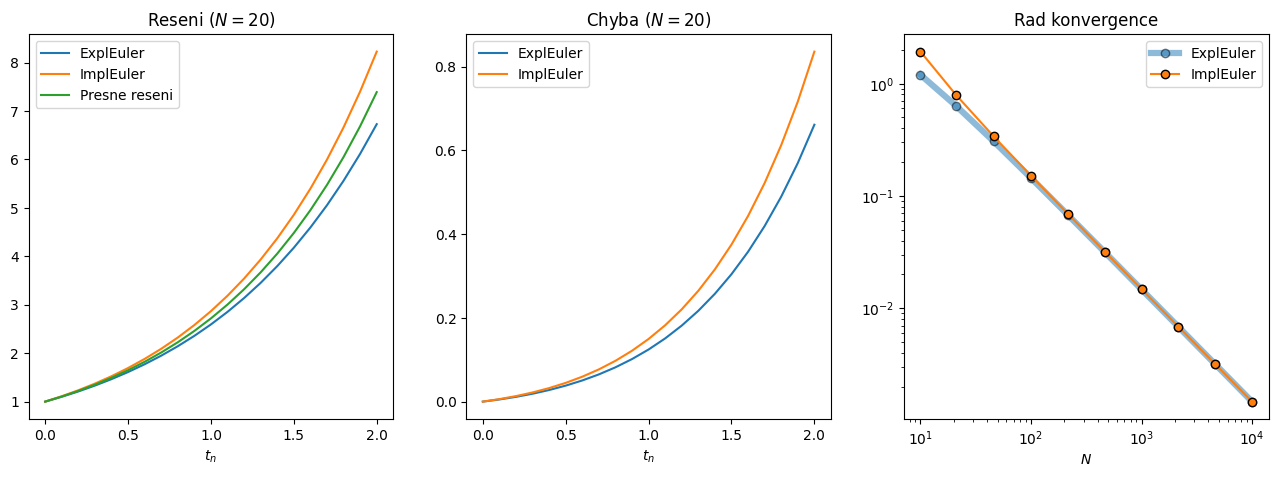

In [ ]:
def Exponenciala_PravaStrana(y,t):
  return y

### Obrazek vlevo & uprostred (N=20)
N = 20; t0 = 0; T = 2; y0 = 1.
t_mesh20, reseni_explEuler20 = ...
err_explEuler = ...

t_mesh20, reseni_implEuler20 = ...
err_implEuler = ...

err_t_mesh = t_mesh20

### Obrazek vpravo (skalovani vuci N)
N_torun = np.logspace(1,4,10, dtype=np.int32)
maxerr_explEuler = np.zeros(len(N_torun)); maxerr_implEuler = np.zeros(len(N_torun))

for ind_N in range(...):

  N = ...

  t_mesh, reseni_explEuler = ...
  maxerr_explEuler[ind_N] = ...

  t_mesh, reseni_implEuler = ...
  maxerr_implEuler[ind_N] = ...



################################################ Vykreslovani
plt.figure(figsize=(16,5))

plt.subplot(1,3,1)
plt.plot(t_mesh20, reseni_explEuler20[0,:], label='ExplEuler')
plt.plot(t_mesh20, reseni_implEuler20[0,:], label='ImplEuler')
plt.plot(t_mesh20, np.exp(t_mesh20), label='Presne reseni')
plt.legend(); plt.title(r'Reseni ($N=20$)'); plt.xlabel(r'$t_n$')

plt.subplot(1,3,2)
plt.plot(err_t_mesh, err_explEuler, label='ExplEuler')
plt.plot(err_t_mesh, err_implEuler, label='ImplEuler')
plt.legend(); plt.title(r'Chyba ($N=20$)'); plt.xlabel(r'$t_n$')

plt.subplot(1,3,3)
plt.loglog(N_torun, maxerr_explEuler,"o-", markeredgecolor="k", lw=4.5, alpha=.5, label='ExplEuler')
plt.loglog(N_torun, maxerr_implEuler,"o-", markeredgecolor="k", label='ImplEuler')
plt.legend(); plt.title(r'Rad konvergence'); plt.xlabel(r'$N$'); plt.show()
################################################ Vykreslovani

### Úloha A3 - a jak to funguje?

Obě Eulerovy metody lze technicky napsat za použití našeho ODRka jako
- explicitní Euler: $\quad \mathbf{y}^{(n+1)} = \mathbf{y}^{(n)} + h \cdot \mathbf{y}'\left( t_n \right),$

- implicitní Euler: $\quad\mathbf{y}^{(n+1)} = \mathbf{y}^{(n)} + h \cdot \mathbf{y}'\left( t_{n+1} \right)$.

Nebo-li $\mathbf{y}^{(n+1)}$ je v obu případech lineární funkce našeho diskrétního kroku $h$, se směrnicí $\mathbf{y}'\left( t_{n} \right)$ nebo $\mathbf{y}'\left( t_{n+1} \right)$ a jeden krok Eulerovy metody spočívá v posunu podél této přímky právě o krok $h$.

---
**Tužka a papír** :

- Pro následující 2 obrázky určete, které aproximace byly spočteny pomocí explicitní Eulerovy metody a které pomocí implicitní Eulerovy metody. Na výběr je ze 3 aproximací (červená, modrá, zelená) přesná řešení $\mathbf{y}(t)$ pro různé pořáteřní podmínky jsou vykreslena šedě/černě.

- Za použití pojmů "odkud/kam a v jakém směru vyrážím/přicházím" vysvětlete rozdíl mezi jedním krokem implicitní a explicitní Eulerovy metody.

---

---
***Řešení:***
- červená je explicitní Euler
- modrá je implicitní Euler
- zelená je jiná metoda (pro zajímavost je to explicitní metoda typu RUnge-Kutta, viz níže)
---

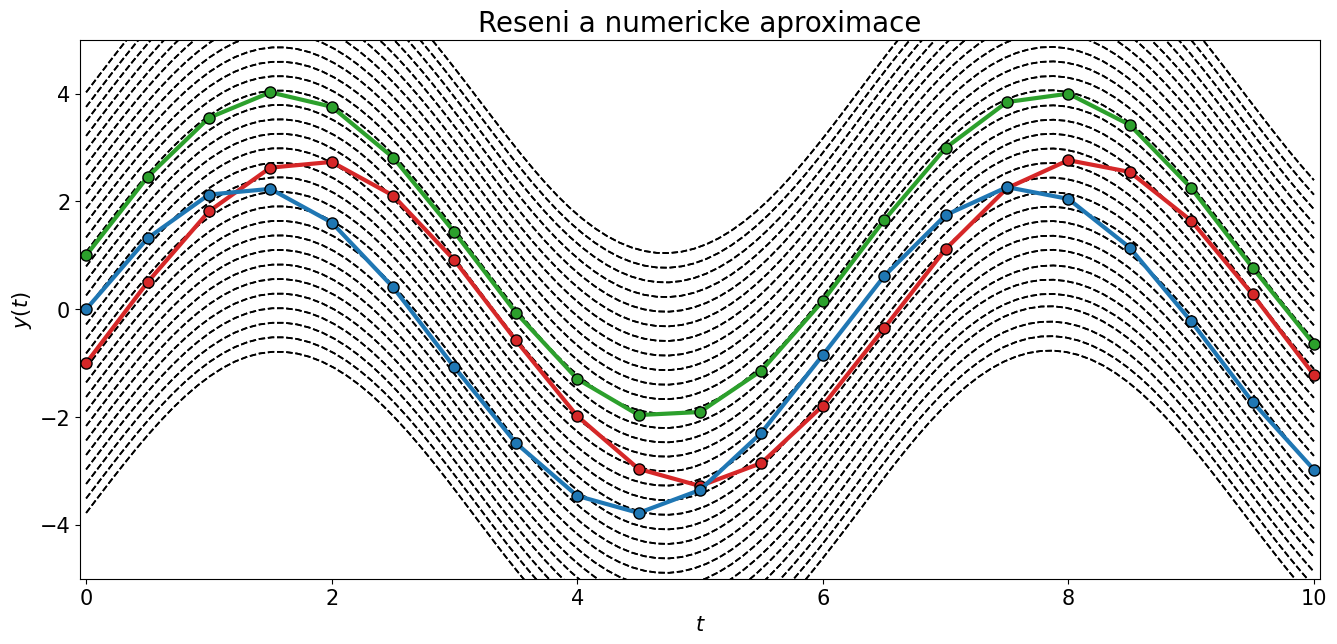

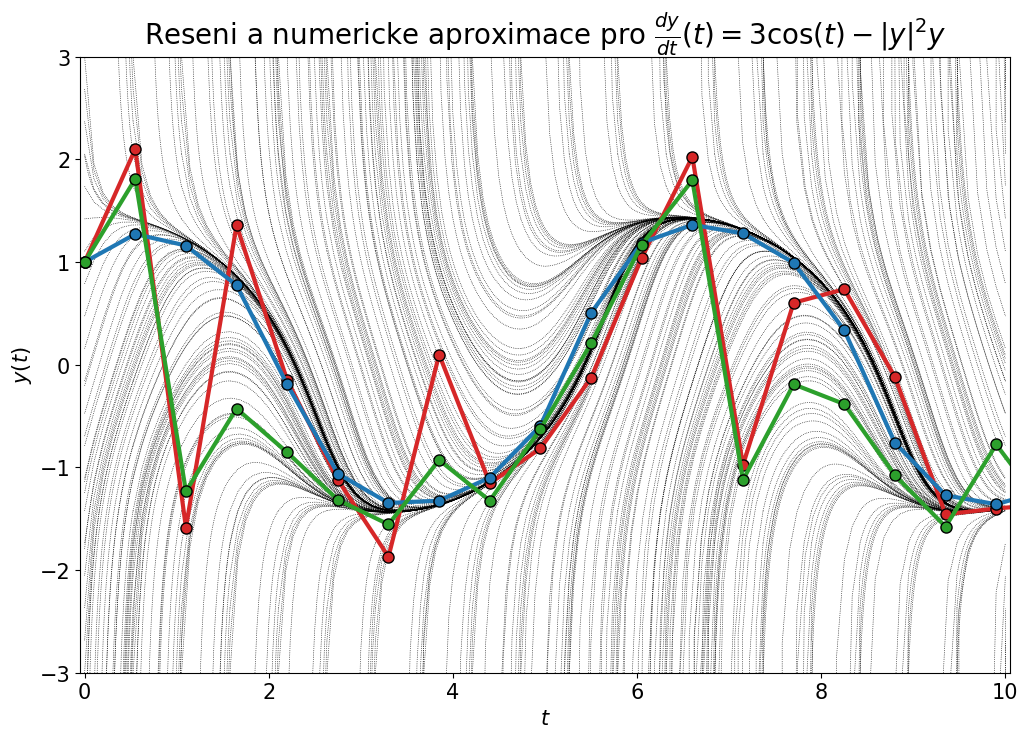

### ZÚ - [králíci a lišky](https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations)

Podíváme se na relativně známý model vývoje soupeřících populací - tzv. Lotka-Volterra systém ODR. Modeluje vývoj dvou populací v závislosti na jejich velikosti - klasicky se první populace označuje jako predátor (liška) a druhá jako kořist (králík). Pokud označíme velikost populace predátorů (nebo kořisti) v čase $t$ jako $p(t)$ (nebo $k(t)$), pak Lotka-Voltera systém je dán jako

$$
\begin{bmatrix}
k'(t)\\
p'(t)
\end{bmatrix} = \begin{bmatrix}
\alpha k(t) - \beta p(t) k(t) \\
\delta p(t) k(t) -\gamma p(t)
\end{bmatrix}
\quad \mathrm{a} \quad
\begin{bmatrix}
k(t_0)\\
p(t_0)
\end{bmatrix} = \begin{bmatrix}
k_0 \\
p_0
\end{bmatrix},
$$

kde nám
- první rovnice říká, že nárůst populace kořisti odpovídá $\alpha$-násobku současné populace kořisti mínus počet ulovených/pošlých kusů kořisti (a ten odhadujeme jako přímo úměrný velikosti populace kořistí a predátorů, s koeficientem $\beta$),
- a druhá rovnice říká, že nárůst populace predátorů je úměrný počtu ulovených/pošlých kusů kořisti (opět přímo úměrný velikosti populací kořistí a predátorů, s koeficientem $\delta$) mínus $\gamma$-krát velikost populace predátorů.

Jde o zjednodušený  model, který ovšem na první pohled dává plus-mínus smysl.

Uvažujme Lotka-Volterra rovnici se všemi koeficienty rovnými 1, tj. s $\alpha = \beta = \gamma = \delta = 1$ a počáteční podmínkou $p_0 = k_0 = 1/2$.

---
**Kódění** :
- Doplňte kód níže tak, aby vykreslil jednoho obrázku:
   - řešení spočítané explicitní Eulerovou metodou v závislosti na čase $t$,
   - řešení spočítané implicitní Eulerovou metodou v závislosti na čase $t$,
   - řešení spočítané `pythonem` v závislosti na čase $t$.
  <details>
  <summary>Chci <font color="red"><b>hint</b></font></summary>

    - použijeme vestavěnou funkci [`solve_ivp`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html#scipy.integrate.solve_ivp) z knihovny `scipy.integrate`.
    - jako inputy musíme dodat naší pravou stranu (input `fun`) a interval $(t_0,T)$ (input `t_span`).
    - v našem případě chceme, aby na výstupu byly hodnoty v bodech `t_mesh`. To odpovídá inputu `t_eval = t_mesh`
    - všimněme si, že input `fun` má být funkce, která má jako první input čas a jako druhý input hodnotu hledané funkce. Jinými slovy, python řešič ODRek očekává pravou stranu `f(t,y)`, zatímco my pracujeme s pravou funkcí `f(y,t)`. Musíme si tedy [vygooglit](https://stackoverflow.com/questions/53310053/python-lambda-function-variable-ordering), jak to spravit.
  </details>

 - Zafixujme $T=35$ a zkusíme vybrat vhodný počet kroků $N$ (nebo-li vhodný diskrétní krok $h = (T-t_0)/N = 35/N$). Přirozeně chceme $N$ co nejmenší, aby výpočet byl co nejrychlejší a museli jsme ukládat co nejméně dat.
    - Jak se kvalitativně liší chování našich třech metod (explicit/implicit Euler a python řešič) pro $N \leq 250$, $N\in [250,500]$ a $N\geq 500$?
    - Jako to ne/odpovídá přednášce?
---

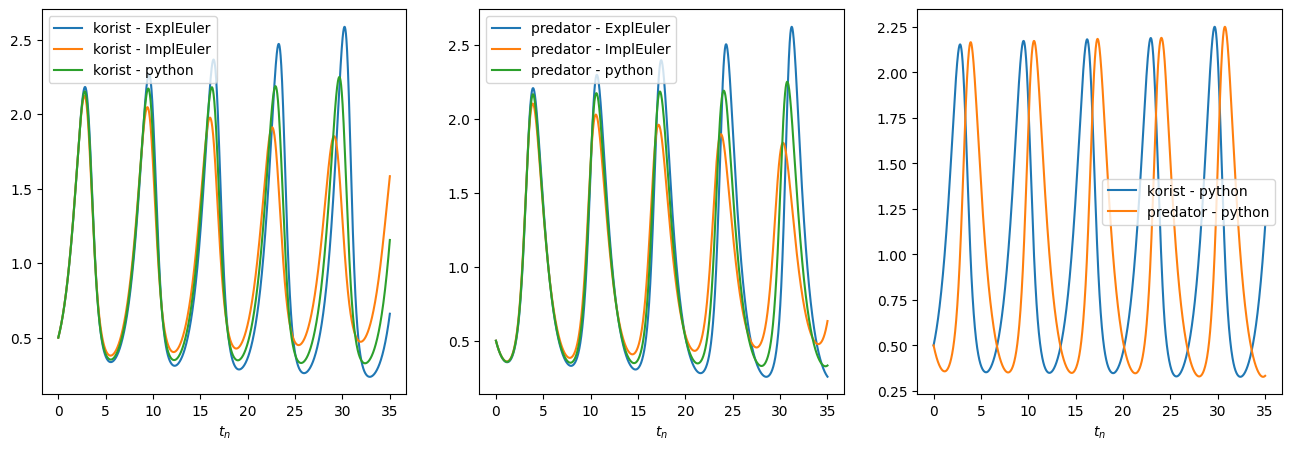

In [ ]:
def LotkaVoltera_PravaStranaObecna(y,t,alpha,beta,gamma,delta):
  return np.asarray([ alpha*y[0] - beta*y[0]*y[1] , -gamma*y[1] + delta*y[0]*y[1]  ])

alpha = 1; beta = 1; gamma = 1; delta = 1
LotkaVoltera_PravaStrana = lambda y,t: LotkaVoltera_PravaStranaObecna(y, t, alpha=alpha,beta=beta,gamma=gamma,delta=delta)
LotkaVoltera_PravaStrana_OpacnePoradi = lambda t,y: LotkaVoltera_PravaStranaObecna(y, t, alpha=alpha,beta=beta,gamma=gamma,delta=delta)



N = 2000; t0 = 0; T = 35; y0 = 0.5*np.ones(2)
t_mesh, reseni_explEuler = ...
t_mesh, reseni_implEuler = ...
Reseni = ...

###################################### Vykreslovani
plt.figure(figsize=(16,5))

plt.subplot(1,3,1)
plt.plot(t_mesh, reseni_explEuler[0,:], label='korist - ExplEuler')
plt.plot(t_mesh, reseni_implEuler[0,:], label='korist - ImplEuler')
plt.plot(t_mesh, Reseni.y[0,:], label='korist - python')
plt.xlabel(r'$t_n$'); plt.legend();

plt.subplot(1,3,2)
plt.plot(t_mesh, reseni_explEuler[1,:], label='predator - ExplEuler')
plt.plot(t_mesh, reseni_implEuler[1,:], label='predator - ImplEuler')
plt.plot(t_mesh, Reseni.y[1,:], label='predator - python')
plt.xlabel(r'$t_n$'); plt.legend();

plt.subplot(1,3,3)
plt.plot(t_mesh, Reseni.y[0,:], label='korist - python')
plt.plot(t_mesh, Reseni.y[1,:], label='predator - python')
plt.xlabel(r'$t_n$')
plt.legend(); plt.show()
###################################### Vykreslovani

### ZÚ - vymřou králíci nebo lišky?

Uvažujme stejný problém jako v A2.

---
**Kódění** :
 - Vypadá to, že přesná řešení by mohla být **periodická** - potvrďte si toto pozorování online (např. [wiki](https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations#A_simple_example) nebo AI).

 - Doplňte kód níže tak, aby vykreslil řešení našich 3 metod na grafu s osami "velikost $k$" a "velikost $p$" (tj. čas bude v tomto grafu pouze implicitní). Čemu na tomto grafu odpovídá periodicita řešení?

 - Zkoušejte různé počáteční podmínky a délky kroku $h$. Jsme schopní najít konstelaci, pro kterou by nějaký z našich řešičů "respektoval" tu periodicitu našeho řešení?
---

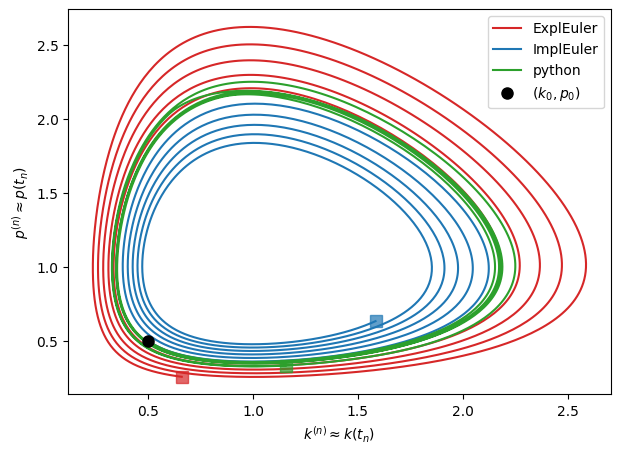

In [ ]:
def LotkaVoltera_PravaStranaObecna(y,t,alpha,beta,gamma,delta):
  return np.asarray([ alpha*y[0] - beta*y[0]*y[1] , -gamma*y[1] + delta*y[0]*y[1]  ])

alpha = 1; beta = 1; gamma = 1; delta = 1
LotkaVoltera_PravaStrana = lambda y,t: LotkaVoltera_PravaStranaObecna(y, t, alpha=alpha,beta=beta,gamma=gamma,delta=delta)
LotkaVoltera_PravaStrana_OpacnePoradi = lambda t,y: LotkaVoltera_PravaStranaObecna(y, t, alpha=alpha,beta=beta,gamma=gamma,delta=delta)



N = 2000; t0 = 0; T = 35; y0 = 0.5*np.ones(2)
t_mesh, reseni_explEuler = ...
t_mesh, reseni_implEuler = ...
Reseni = ...


###################################### Vykreslovani
plt.figure(figsize=(7,5))

plt.subplot(1,1,1)
plt.plot(reseni_explEuler[0,:], reseni_explEuler[1,:], label='ExplEuler', c='tab:red')
plt.plot(reseni_explEuler[0,-1], reseni_explEuler[1,-1], 's', c='tab:red', ms=8,alpha=.7)
plt.plot(reseni_implEuler[0,:], reseni_implEuler[1,:], label='ImplEuler', c='tab:blue')
plt.plot(reseni_implEuler[0,-1], reseni_implEuler[1,-1], 's', c='tab:blue', ms=8,alpha=.7)
plt.plot(Reseni.y[0,:], Reseni.y[1,:], label='python', c='tab:green')
plt.plot(Reseni.y[0,-1], Reseni.y[1,-1], 's', c='tab:green', ms=8,alpha=.7)
plt.plot(Reseni.y[0,0], Reseni.y[1,0], 'ko', ms=8, label=r'$(k_0,p_0)$');
plt.xlabel(r'$k^{(n)} \approx k(t_n)$'); plt.ylabel(r'$p^{(n)} \approx p(t_n)$')
plt.legend(); plt.show()
###################################### Vykreslovani

### Navíc pro nadšence - vymírání kvůli pythonu nebo kvůli modelu?

Tohle je fakt navíc - není nutné pro úspěšné splnění zápočtového projektu.

Pro set-up z A2 jsme viděli, že teoretické řešení k těmto rovnicím má něco čemu říkáme "invariant" - hodnota nebo kombinace hodnot řešení, která se s časem nemění. Není důvod se domnívat, že obecné metody budou takovou věc "respektovat", tj. tato hodnota taky zůstane konstantní pro naše $\mathbf{y}^{(1)},\mathbf{y}^{(2)},\mathbf{y}^{(3)}, \dotsc$. To je naprosto běžná věc - v praxi třeba chceme aby se v jistém dynamickém systéme zachovávala energie, aby se neměnil tlak a nebo aby se nezvyšovala entropie.

Důležitá část numerické matematiky je vymýšlet numerické metody, které zachovávají fyzikálně/sociologicky/ekonomicky relevantní zákony (bez vnějšího zásahu budou populace kořistí a predátorů oscilovat a ani jedna nevyhyne ani nebude růst nead určitou mez) i při numerické simulaci. Pro systémy typu Lotka-Voltera (obecně jsou to soustavy tzv. Hamiltoniánů - pojem z teoretické mechaniky, o kterém sae můžete dozvědět více na přednášce [teoretické mechaniky](https://is.cuni.cz/studium/predmety/index.php?do=predmet&kod=NOFY003) - podle mě asi ten nejlépe udělaný a odpřednášený kurz na MFF) se toto "zachovávání" dá docílit pomocí tzv. *symplektických metod* -- metod, které zachovávají plochu.

My si zkusíme tu nejjednodušší symplektickou metodu - explicitní symplektickou Eulerovu metodu.

Explicitní symplektická Eulerova metoda pro
$$
\begin{bmatrix} y_1 \\ y_2 \end{bmatrix} '(t) = \begin{bmatrix} f_1(y_1^{(n)}(t),y_2^{(n)}(t),t) \\ f_2(y_1^{(n)}(t),y_2^{(n)}(t),t) \end{bmatrix}
\quad \mathrm{a} \quad
\mathbf{y}(t_0) = \mathbf{y}^{(0)}
$$

je dána jako

$$
\begin{bmatrix} y_1^{(n+1)} \\ y_2^{(n+1)} \end{bmatrix} =
\begin{bmatrix} y_1^{(n)} \\ y_2^{(n)} \end{bmatrix} + \tau \cdot
\underbrace{\begin{bmatrix} f_1(y_1^{(n)},y_2^{(n)},t_n) \\ f_2(y_1^{(n+1)},y_2^{(n)},t_{n+1}) \end{bmatrix}}_{ =: \mathbf{\Phi}(\mathbf{y}^{(n)},t_n,\tau)}
$$


---
 - Naimplementujte explicitní symplektickou Eulerovu metodu a ověřte si správnost vizuálně - mělo by docházet k perfektnímu zachovávání periodicity.
 - Numerickými výpočty (analogicky jako v A1) odhadněte řád konvergence této metody.
 - **Tužka+papír**: Dokažte, že explicitní symplektická Eulerova metoda má předvídaný řád konvergence.
 - popis "metody, které zachovávají plochu" použitý výše, je naprosto přesný. Zkuste si zkonstruovat čtverec z počátečních podmínek a podívat se jak se bude měnit plocha tohoto čtverce, když ho necháte "se vyvíjet" pomocí našich tří různých metod typu Euler. Co se děje s plochou výsledného objektu po několika krocích?
---

## Část B: Metody typu [Runge-Kutta](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods)


Metody typu Runge-Kutta jsou v jistém smyslu přirozeným zobecněním Eulerových metod. Existují impliccitní i explicitní a pro každou z těchto variant jich navíc existuje celá řada. Runge-Kutta metody jsou jednokrokové a tedy je opět můžeme napsat ve tvaru

$$
\mathbf{y}(t_{n+1})  \approx \mathbf{y}^{(n+1)} =
\mathbf{y}^{(n)} + h \cdot \mathbf{\Phi}\left( t_n,\mathbf{y}^{(n)},h\right),
$$

kde přírůstková funkce $\mathbf{\Phi}$ je následujícího tvaru

$$
\mathbf{\Phi}(\mathbf{y}^{(n)},t_n,h) = b_1\mathbf{k}_1 + b_2\mathbf{k}_2 + \cdots + b_s\mathbf{k}_s.
$$

Tedy $\mathbf{\Phi}(\mathbf{y}^{(n)},t_n,h)$ je definována jako lineárí kombinaci tzv. "stage functions/vectors" $\mathbf{k}_1,\cdots ,\mathbf{k}_s$ s koeficienty $b_1,\dotsc ,b_s$.


- ***Koeficienty*** Každá Runge-Kutta metoda je definovaná koeficienty $b_1,\dotsc ,b_s$, $c_1,\dotsc ,c_s$ a $a_{11},\dotsc ,a_{1s},\dotsc ,a_{ss}$. Většinou je zapisujeme do tzv. "Butcher table/tableau" (někdy také "Runge-Kutta table/tableau"):

  \begin{array}{l|lll}
  c_1	  & a_{11} & \dots &  a_{1s}\\
  \vdots	& \vdots & \ddots &  \vdots\\
  c_s	  & a_{s1} & \dots &  a_{ss}\\
  \hline
  & b_1 & \dots & b_{s} \\
  \end{array}

  často zkracovaném v zápise "vektor, matice, vektor"

  \begin{array}{l|l}
  \mathbf{c} & A\\
  \hline
  & \mathbf{b} \\
  \end{array}


- ***Vektory*** $\mathbf{k}_1,\cdots ,\mathbf{k}_s$ závisí na konkrétním ODR a na čase $t_n$ a jsou obecně dány skrze soustavu $s$ rovnic

$$
\begin{equation}
\mathbf{k}_1 = \mathbf{f} \left(\mathbf{y}^{(n)} + h (a_{11} \mathbf{k}_1 + \dotsc + a_{1s} \mathbf{k}_s) ,  t_n + c_1 h \right), \\
\mathbf{k}_2 = \mathbf{f} \left(\mathbf{y}^{(n)} + h (a_{21} \mathbf{k}_1 + \dotsc + a_{2s} \mathbf{k}_s) ,  t_n + c_2 h \right), \\ \vdots \\
\mathbf{k}_s = \mathbf{f} \left(\mathbf{y}^{(n)} + h (a_{s1} \mathbf{k}_1 + \dotsc + a_{ss} \mathbf{k}_s) ,  t_n + c_s h \right).
\end{equation}
$$

Vidíme, že pokud $A$ bude striktně dolní trojúhelníková (tj. pokud její horní trojúhelníková část je nulová, nebo-li $a_{ij}=0$ pro $i\leq j$), pak nejde v pravém slova smyslu o soustavu rovnic - stačí pouze vyčíslovat a dosazovat. Takové Runge-Kutta metody se nazávají *explicitní*. V opačném případě musíme opravdu řešit soustavu (možná nelineárních) algebraických rovnic, abychom získali $\mathbf{k}_1,\cdots ,\mathbf{k}_s$ a pomocí nich následně $\mathbf{y}^{(n+1)}$ - v takovém případě se jedná o *implicitní* Runge-Kutta metodu.

Zároveň vidíme, že tento proces (ať už explicitní nebo implicitní) je nutno opakovat v každém kroku, protože $\mathbf{k}_1,\cdots ,\mathbf{k}_s$ zjevně závisí na $\mathbf{y}^{(n)}$.

Runge-Kutta metody mají jednu výraznou výhodu oproti Eulerovým metodám - díky mnoha volným parametrů ($2s+s^2$) s nimi můžeme dosáhnout výrazně vyššího řádu konvergence (pro vhodnou, univerzální volbu těchto parametrů).

### Úloha B1 - implementace

---
**Kódění** : Naimplementujte funkci `Euler_expl()` podle anotace níže.

----

In [ ]:
def RK_expl(f, t0, T, y0, N, A, b, c):
  """
  Vypocteme aproximaci reseni systemu ODR
      y' = f(y,t)    &&    y(t0) = y0
  pomoci explicitni Runge-Kutta metody s Butcher table c|A|b.

  Input
  ----------
  f :   python funkce (callable). Funkce vyhodnocujici pravou stranu "f : R^{n} x R --> R",
        syntax "f( np.array([y1,...,yd]) , t )" vraci numpy array dimenze "d"
  t0,T : np.float64. Levy a prajni okraj casoveho intervalu
  y0 : np.array dimenze "d". Pocatecni podminka v case t0 - udava velikost systemu
  N : np.int32. Pocet kroku, ktere ma Explicitni Eulerova metoda udelat
  A,b,c : Butcher table -> protoze toto je explicitni Runge-Kutta metoda, budeme pouzivat jen striktne spodni trojuhelnikovou cast A
      A : np.array dimenze "s-krat-s". Koeficienty "posunu v prostoru" pro soustavu rovnic k nalezeni stage functions
      b : np.array dimenze "s". Koeficienty linearni kombinace v definici Phi
      c : np.array dimenze "s". Koeficienty "posunu v case" pro soustavu rovnic k nalezeni stage functions

  Output
  -------
  t_mesh : np.array dimenze N+1. Vektor obsahujici vsechny body t0, t_1=t0+tau, ..., t_N=T
  y : np.array dimenze np.size(y0)-krat-(N+1). Matice, v jejiz sloupcich jsou aproximace y^(n) reseni y(t) v bodech t_0, t_1, ..., t_N. Tedy [y^0, y^1, ..., y^N]
  """
  # Vas kod
  s = len(b)
  t_mesh = np.linspace(t0,T,N+1); tau = (T-t0)/N
  y = np.nan*np.zeros((np.size(y0),N+1))

  # to jen pro jistotu, tohle by melo platit automaticky, jinak to neni explicitni metoda
  for i in range(0,s):
    for j in range(0,s):
      if i <= j:
        A[i,j] = 0

  y[:,0] = y0
  for n in range(0,N):
    k = np.zeros((np.size(y0),s))
    for i in range(0,s):
      k[:,i] = f(y[:,n] + tau * np.dot(k,A[i,:]),t_mesh[n] + c[i]*tau)

    y[:,n+1] = y[:,n] + tau * np.dot(k,b)
  return t_mesh, y


######################################################################
def test_ExplRK():
  def TestRHSFun1(y,t):
    return np.zeros_like(y)
  def TestRHSFun2(y,t):
    return np.ones_like(y)
  def TestRHSFun4(y,t):
    return -y+t
  def TestRHSFun5(y,t):
    A = np.asarray([[1,1],[0,1]])
    return A.dot(y) + np.asarray([t,2*t])

  A_expl = np.asarray([[0,0],[1,0]]); b_expl = np.asarray([1/2,1/2]); c_expl = np.asarray([0,1])

  N = 5; t0 = 0; T = 1; y0 = np.ones(3)
  t_mesh, y = RK_expl(TestRHSFun1, t0, T, y0, N, A_expl, b_expl, c_expl)
  assert np.allclose(t_mesh, np.asarray([0.0,0.2,0.4,0.6,0.8,1.])), "ExplRK: Spatne generovany time-stepping"
  assert np.allclose(y, np.ones((3,N+1))), "ExplRK: pocatecni podminka + nulova prava strana -> reseni by melo byt konstantni, rovne pocatec. podm., ale spravnych rozmeru."
  t_mesh, y = RK_expl(TestRHSFun2, t0, T, y0, N, A_expl, b_expl, c_expl)
  assert np.allclose(y, np.outer(np.ones_like(y0),t_mesh) + np.outer(y0,np.ones_like(t_mesh)) ), "ExplRK: pocatecni podminka + f(y,t) = const -> ExplRK by mel byt presny -> reseni by melo byt y(t) = t * np.ones_like(y0) + y0."
  N = 10; t0 = 1; T = 2; y0 = np.zeros(3)
  y = RK_expl(TestRHSFun4, t0, T, y0, N, A_expl, b_expl, c_expl)[1]
  assert np.allclose(y, 0.1*np.arange(0,11,1)), "ExplRK: Spatne reseni - zkontrolovat pomoci papir+tuzka"
  N = 3; t0 = 1; T = 1.3; y0 = np.zeros(2)
  y = RK_expl(TestRHSFun5, t0, T, y0, N, A_expl, b_expl, c_expl)[1]; explRK_sol = np.asarray([[0,0.12,0.2883,0.5148225],[0,0.22,0.4841,0.7969305]])
  assert np.allclose(y, explRK_sol), "ExplRK: Spatne reseni - najit chybu zeptat se cviciho"

  return '"RK_expl()" je OK'

test_ExplRK()

'"RK_expl()" je OK'

In [ ]:
def RK_impl(f, t0, T, y0, N, A, b, c):
  """
  Vypocteme aproximaci reseni systemu ODR
      y' = f(y,t)    &&    y(t0) = y0
  pomoci implicitni Runge-Kutta metody s Butcher table c|A|b.

  Input
  ----------
  f :   python funkce (callable). Funkce vyhodnocujici pravou stranu "f : R^{n} x R --> R",
        syntax "f( np.array([y1,...,yd]) , t )" vraci numpy array dimenze "d"
  t0,T : np.float64. Levy a prajni okraj casoveho intervalu
  y0 : np.array dimenze "d". Pocatecni podminka v case t0 - udava velikost systemu
  N : np.int32. Pocet kroku, ktere ma Explicitni Eulerova metoda udelat
  A,b,c : Butcher table -> protoze toto je implicitni Runge-Kutta metoda, budeme pouzivat celou matici A
      A : np.array dimenze "s-krat-s". Koeficienty "posunu v prostoru" pro soustavu rovnic k nalezeni stage functions
      b : np.array dimenze "s". Koeficienty linearni kombinace v definici Phi
      c : np.array dimenze "s". Koeficienty "posunu v case" pro soustavu rovnic k nalezeni stage functions

  Output
  -------
  t_mesh : np.array dimenze N+1. Vektor obsahujici vsechny body t0, t_1=t0+tau, ..., t_N=T
  y : np.array dimenze np.size(y0)-krat-(N+1). Matice, v jejiz sloupcich jsou aproximace y^(n) reseni y(t) v bodech t_0, t_1, ..., t_N. Tedy [y^0, y^1, ..., y^N]
  """
  from scipy.optimize import fsolve

  # Vas kod
  def F_FceProImplRK(k_vec, y_n,tn,tau, A,c):
    output = np.zeros_like(k_vec); s = len(c); y_size = np.size(y_n)
    for i in range(0,s):
      f_i = f(y_n + tau * np.dot(k_vec.reshape((y_size,s), order='F'),A[i,:]),tn + c[i]*tau)
      output[i*y_size:(i+1)*y_size] = k_vec[i*y_size:(i+1)*y_size] - f_i
    return output

  s = len(b); y_size = np.size(y0); t_mesh = np.linspace(t0,T,N+1); tau = (T-t0)/N; y = np.nan*np.zeros((np.size(y0),N+1))
  y[:,0] = y0; k_vectorize = np.tile(y0,s)
  for n in range(0,N):
    k_vectorize = fsolve(F_FceProImplRK,k_vectorize,args=(y[:,n],t0+n*tau,tau, A,c))
    y[:,n+1] = y[:,n] + tau * np.dot( k_vectorize.reshape((y_size,s), order='F'), b)
  return t_mesh, y

### Úloha B2 - jak to funguje?

Opět si vezmeme skalární ODRko

$$ y'(t) = y(t), \; y(0)=1, \; t\in [0,2] $$

a následující dvě Butcher tables (pro $s=2$ jsou toto explicitní a implicitní Runge-Kutta metody s nejvyšším řádem $p$)

$$
A_{expl} = \begin{bmatrix} 0 & 0 \\ \frac{1}{2} & 0 \end{bmatrix}, \mathbf{b}_{expl} = \begin{bmatrix} 0 \\ 1 \end{bmatrix}, c_{expl} = \begin{bmatrix} 0 \\ \frac{1}{2} \end{bmatrix} \\
A_{impl} = \begin{bmatrix} \frac{5}{12} & -\frac{1}{12} \\ \frac{3}{4} & \frac{1}{4} \end{bmatrix}, \mathbf{b}_{impl} = \begin{bmatrix} \frac{3}{4} \\ \frac{1}{4} \end{bmatrix}, c_{impl} = \begin{bmatrix} \frac{1}{3} \\ 1 \end{bmatrix}
$$

---
**Kódění** :

  - Doplňte kód níže tak, aby vykreslil přesné řešení a jeho aproximaci pomocí obou Runge-Kutta metod jako funkci $t_n = n\cdot h$ do jednoho grafu.
  - Doplňte kód níže tak, aby vykreslil aproximační chybu $err_f(N,n) = |y(t_n) - y^{(n)}|$ pro obě Runge-Kutta metody jako funkci $t_n = t_0 + n\cdot h$ do jednoho grafu.
  - Doplňte kód níže tak, aby vykreslil $E_f(N) = C\cdot h$ pro obě Runge-Kutta metody jako funkci $N$ pro $N$ mezi $10$ a $10^4$. Odhadněte řád těchto metod podle vašich výsledků.
---

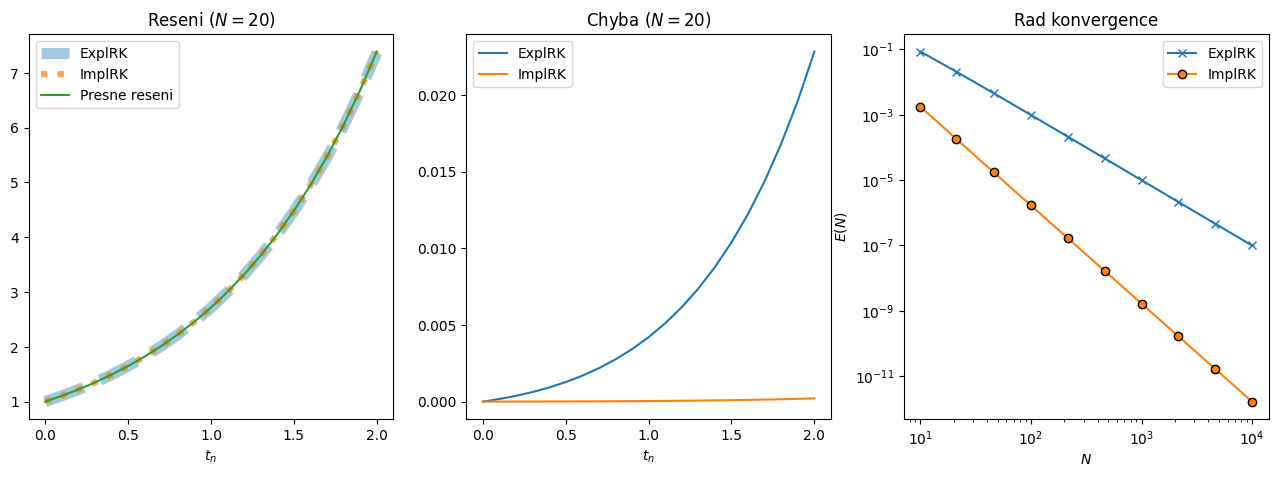

In [ ]:
def Exponenciala_PravaStrana(y,t):
  return y

A_expl = np.asarray([[0,0],[1/2,0]]); b_expl = np.asarray([0,1]); c_expl = np.asarray([0,1/2])
A_impl = np.asarray([[5/12,-1/12],[3/4,1/4]]); b_impl = np.asarray([3/4,1/4]); c_impl = np.asarray([1/3,1])

### obrazek vlevo a uprostred (N=20)
N = 20; t0 = 0; T = 2; y0 = 1.
t_mesh20, reseni_explRK20 = ...
err_explRK20 = ...

t_mesh20, reseni_implRK20 = ...
err_implRK20 = ...

err_t_mesh = t_mesh20


### obrazek vpravo (skalovani vuce zvetsujicimu se N)
N_torun = np.logspace(1,4,10, dtype=np.int32)
maxerr_explRK = np.zeros(len(N_torun)); maxerr_implRK = np.zeros(len(N_torun))

for ind_N in range(0,len(N_torun)):

  N = ...

  t_mesh, reseni_explRK = ...
  maxerr_explRK[ind_N] = ...

  t_mesh, reseni_implRK = ...
  maxerr_implRK[ind_N] = ...


########################################################## Vykreslovani
plt.figure(figsize=(16,5))

plt.subplot(1,3,1)
plt.plot(t_mesh20, reseni_explRK20[0,:], '--', lw=8, alpha=.4, label='ExplRK')
plt.plot(t_mesh20, reseni_implRK20[0,:], ':', lw=4.5, alpha=.7, label='ImplRK')
plt.plot(t_mesh20, np.exp(t_mesh20), label='Presne reseni')
plt.legend(); plt.title(r'Reseni ($N=20$)'); plt.xlabel(r'$t_n$')

plt.subplot(1,3,2)
plt.plot(err_t_mesh, err_explRK20, label='ExplRK')
plt.plot(err_t_mesh, err_implRK20, label='ImplRK')
plt.legend(); plt.title(r'Chyba ($N=20$)'); plt.xlabel(r'$t_n$')

plt.subplot(1,3,3)
plt.loglog(N_torun, maxerr_explRK,"o-", markeredgecolor="k", label='ExplRK')
plt.loglog(N_torun, maxerr_implRK,"o-", markeredgecolor="k", label='ImplRK')
plt.legend(); plt.title('Rad konvergence'); plt.xlabel(r'$N$'); plt.ylabel(r'$E(N)$'); plt.show()
########################################################## Vykreslovani

## Část C: [Stiff rovnice](https://en.wikipedia.org/wiki/Stiff_equation#) \& [stabilita](https://en.wikipedia.org/wiki/Stiff_equation#A-stability)


Vezmeme si následující skalární ODRko

$$
y'(t) = \frac{1}{\varepsilon} \left( -y(t) + \cos(t) \right), \quad y(0) = 0
$$

a vyzkoušíme si na něj použít všechny metody pro řešení ODR, které máme naimplementované - explicitní a implicitní Euler a metody "explicit mid-point" (odpovídá explicitní RK v B1) a "two-stage RadauIIA" (odpovídá implicitní RK v B1).

### Úloha C1 - jsou implicitní metody lepší "pouze" ve smyslu řádu konvergence?

---
**Kódění** :
- Vezmeme si $\varepsilon = 0.05$ a $t_0=0, T=1, y_0=0,N=20$. Doplňte kód níže tak, aby vykreslil graf s
  - aproximací řešení oběmi Eulerovými metodami
  - aproximací řešení oběmi metodami Runge-Kutta
  - "přesným" řešením (spočteným pomocí `solve_ivp()`).

- Vezmeme si $\varepsilon = 0.02$ a $t_0=0, T=1, y_0=0,N=20$. Doplňte kód níže tak, aby vykreslil graf s
  - aproximací řešení oběmi Eulerovými metodami
  - aproximací řešení oběmi metodami Runge-Kutta
  - "přesným" řešením (spočteným pomocí `solve_ivp()`).
---

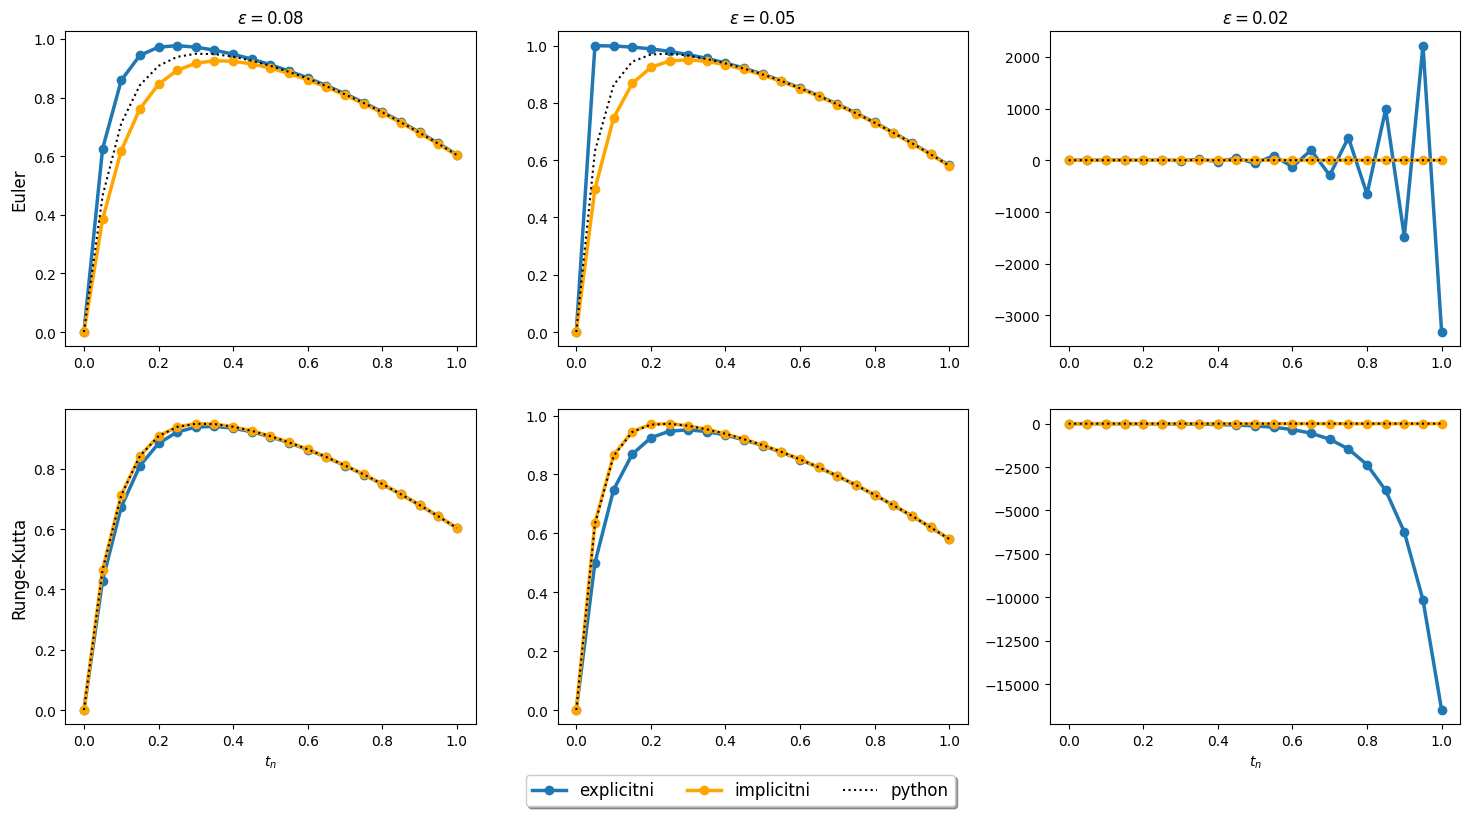

In [ ]:
def StiffRce_PravaStranaObecna(y,t,epsilon):
  return 1/epsilon * (-y + np.cos(t))

StiffRce_PravaStrana = lambda y,t: StiffRce_PravaStranaObecna(y, t, epsilon=epsilon)
StiffRce_PravaStrana_OpacnePoradi = lambda t,y: StiffRce_PravaStranaObecna(y, t, epsilon=epsilon)

N = 20; t0 = 0; T = 1; y0 = 0
A_expl = np.asarray([[0,0],[1/2,0]]); b_expl = np.asarray([0,1]); c_expl = np.asarray([0,1/2])
A_impl = np.asarray([[5/12,-1/12],[3/4,1/4]]); b_impl = np.asarray([3/4,1/4]); c_impl = np.asarray([1/3,1])


epsilon = 0.08;
t_mesh, reseni_explEuler_eps008 = Euler_expl(StiffRce_PravaStrana, t0, T, y0, N)
t_mesh, reseni_implEuler_eps008 = Euler_impl(StiffRce_PravaStrana, t0, T, y0, N)
t_mesh, reseni_explRK_eps008 = RK_expl(StiffRce_PravaStrana, t0, T, y0, N, A_expl, b_expl, c_expl)
t_mesh, reseni_implRK_eps008 = RK_impl(StiffRce_PravaStrana, t0, T, y0, N, A_impl, b_impl, c_impl)
Reseni_eps008 = solve_ivp(StiffRce_PravaStrana_OpacnePoradi, (t0,T), np.asarray([y0]), t_eval=t_mesh)

epsilon = 0.05;
t_mesh, reseni_explEuler_eps005 = Euler_expl(StiffRce_PravaStrana, t0, T, y0, N)
t_mesh, reseni_implEuler_eps005 = Euler_impl(StiffRce_PravaStrana, t0, T, y0, N)
t_mesh, reseni_explRK_eps005 = RK_expl(StiffRce_PravaStrana, t0, T, y0, N, A_expl, b_expl, c_expl)
t_mesh, reseni_implRK_eps005 = RK_impl(StiffRce_PravaStrana, t0, T, y0, N, A_impl, b_impl, c_impl)
Reseni_eps005 = solve_ivp(StiffRce_PravaStrana_OpacnePoradi, (t0,T), np.asarray([y0]), t_eval=t_mesh)

epsilon = 0.02;
t_mesh, reseni_explEuler_eps002 = Euler_expl(StiffRce_PravaStrana, t0, T, y0, N)
t_mesh, reseni_implEuler_eps002 = Euler_impl(StiffRce_PravaStrana, t0, T, y0, N)
t_mesh, reseni_explRK_eps002 = RK_expl(StiffRce_PravaStrana, t0, T, y0, N, A_expl, b_expl, c_expl)
t_mesh, reseni_implRK_eps002 = RK_impl(StiffRce_PravaStrana, t0, T, y0, N, A_impl, b_impl, c_impl)
Reseni_eps002 = solve_ivp(StiffRce_PravaStrana_OpacnePoradi, (t0,T), np.asarray([y0]), t_eval=t_mesh)


########################################################## Vykreslovani
MyFig = plt.figure(figsize=(18,9))
MyColors = ["tab:blue","orange","k","tab:green","tab:red"]

plt.subplot(2,3,1)
plt.plot(t_mesh, reseni_explEuler_eps008[0,:], "o-", c=MyColors[0], lw=2.5)
plt.plot(t_mesh, reseni_implEuler_eps008[0,:], "o-", c=MyColors[1], lw=2.5)
plt.plot(t_mesh, Reseni_eps008.y[0,:], ":", c=MyColors[2])
plt.title(r'$\varepsilon = 0.08$'); plt.ylabel(r'Euler',fontsize=12)

plt.subplot(2,3,2)
plt.plot(t_mesh, reseni_explEuler_eps005[0,:], "o-", c=MyColors[0], lw=2.5)
plt.plot(t_mesh, reseni_implEuler_eps005[0,:], "o-", c=MyColors[1], lw=2.5)
plt.plot(t_mesh, Reseni_eps005.y[0,:], ":", c=MyColors[2])
plt.title(r'$\varepsilon = 0.05$');

plt.subplot(2,3,3)
plt.plot(t_mesh, reseni_explEuler_eps002[0,:], "o-", c=MyColors[0], lw=2.5)
plt.plot(t_mesh, reseni_implEuler_eps002[0,:], "o-", c=MyColors[1], lw=2.5)
plt.plot(t_mesh, Reseni_eps002.y[0,:], ":", c=MyColors[2])
plt.title(r'$\varepsilon = 0.02$');


plt.subplot(2,3,4)
plt.plot(t_mesh, reseni_explRK_eps008[0,:], "o-", c=MyColors[0], lw=2.5)
plt.plot(t_mesh, reseni_implRK_eps008[0,:], "o-", c=MyColors[1], lw=2.5)
plt.plot(t_mesh, Reseni_eps008.y[0,:], ":", c=MyColors[2])
plt.ylabel(r'Runge-Kutta',fontsize=12); plt.xlabel(r'$t_n$');

plt.subplot(2,3,5)
plt.plot(t_mesh, reseni_explRK_eps005[0,:], "o-", c=MyColors[0], lw=2.5)
plt.plot(t_mesh, reseni_implRK_eps005[0,:], "o-", c=MyColors[1], lw=2.5)
plt.plot(t_mesh, Reseni_eps005.y[0,:], ":", c=MyColors[2])

plt.subplot(2,3,6)
plt.plot(t_mesh, reseni_explRK_eps002[0,:], "o-", c=MyColors[0], lw=2.5, label='explicitni')
plt.plot(t_mesh, reseni_implRK_eps002[0,:], "o-", c=MyColors[1], lw=2.5, label='implicitni')
plt.plot(t_mesh, Reseni_eps002.y[0,:], ":", c=MyColors[2], label='python')
plt.xlabel(r'$t_n$');

MyFig.legend(loc='lower center', bbox_to_anchor=(0.5,.01), fancybox=True, shadow=True, ncol=5, fontsize=12); plt.xlabel(r'$t_n$');
plt.show()
########################################################## Vykreslovani

### Úloha C2 - jak se chová chyba?

Při pohledu na grafy v pravém sloupci by se nabízelo vysvětlení typu "za oscilace může akumulace zaokrouhlovacích chyb", protože oscilace se objevují "až při menších hodnotách parametrů". Tak se přesvědčíme, jestli tomu tak opravdu je.



---
**Kódění** :
- Ověřte, zda volba menšího parametru $\varepsilon$, například $\varepsilon = 0.01$, opravdu vede k ještě horší aproximaci řešení.
- Zafixujeme si $\varepsilon = 0.01$ a $t_0=0, T=1, y_0=0$.  
Doplňte kód níže tak, aby vykreslil $E_f(N)$ jako funkci $N$ v *log-log* grafu pro každou z našich čtyř metod.
  - místo přesného řešení opět použijeme pythonovské řešení pomocí `solve_ivp()`.

- Proč vidíme, že chyba pro velká $N$ přestane klesat? Opravte kód tak, aby chyby klesali pro všechna vykreslená $N$.
  <details>
    <summary>Chci <font color="red"><b>hint</b></font></summary>
    
    Jak *přesné* je vlastně to naše "přesné" pythonovské řešení? V dokumentaci [`solve_ivp()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html#scipy.integrate.solve_ivp) si vyhledejte význam a default nastavení parametrů `atol` a `rtol`.
  </details>

**Tužka a papír** :
- Co lze z grafu a z grafů v C2 usoudit o porovnání explicitní vs. implicitní metody?

- Podporují numerické experimenty ideu, že problém je v zaokrouhlování, tj. že primárním problémem je výpočet v počítači a nikoliv ve smyslu tužka-a-papír?

---

/tmp/ipython-input-1943216352.py:31: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  y[:,n+1] = fsolve(F_FceProImplEuler,y[:,n],args=(y[:,n],t_mesh[n],h))


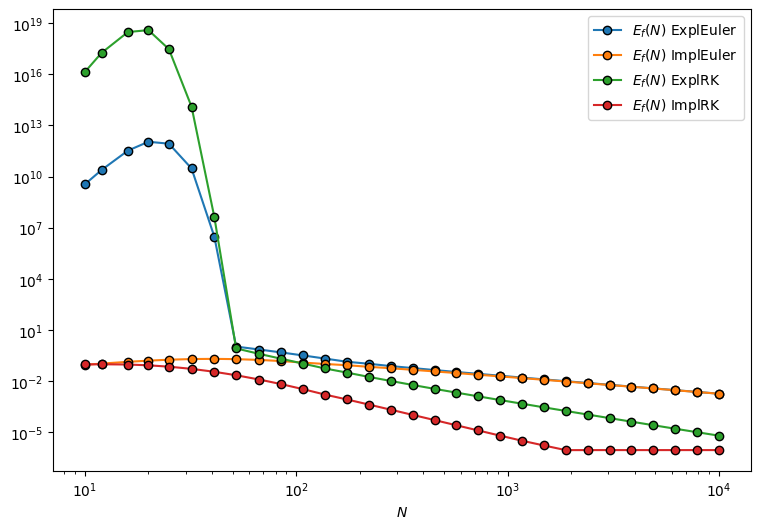

In [ ]:
def StiffRce_PravaStranaObecna(y,t,epsilon):
  return 1/epsilon * (-y + np.cos(t))

StiffRce_PravaStrana = lambda y,t: StiffRce_PravaStranaObecna(y, t, epsilon=epsilon)
StiffRce_PravaStrana_OpacnePoradi = lambda t,y: StiffRce_PravaStranaObecna(y, t, epsilon=epsilon)

t0 = 0; T = 1; y0 = 0
A_expl = np.asarray([[0,0],[1/2,0]]); b_expl = np.asarray([0,1]); c_expl = np.asarray([0,1/2])
A_impl = np.asarray([[5/12,-1/12],[3/4,1/4]]); b_impl = np.asarray([3/4,1/4]); c_impl = np.asarray([1/3,1])

epsilon = 0.01;
N_torun = np.append( np.arange(10,45,5), np.arange(50,1000,50) )
N_torun = np.logspace(1,4,30, dtype=np.int32)
maxerr_explEuler = np.zeros(len(N_torun)); maxerr_implEuler = np.zeros(len(N_torun))
maxerr_explRK = np.zeros(len(N_torun)); maxerr_implRK = np.zeros(len(N_torun))

for ind_N in range(0,len(N_torun)):

  N = N_torun[ind_N]

  t_mesh, reseni_explEuler = Euler_expl(StiffRce_PravaStrana, t0, T, y0, N)
  Reseni = solve_ivp(StiffRce_PravaStrana_OpacnePoradi, (t0,T), np.asarray([y0]), t_eval=t_mesh, rtol=1e-6, atol=1e-6)
  maxerr_explEuler[ind_N] = np.max(np.abs(reseni_explEuler[0,:] - Reseni.y[0,:]))

  t_mesh, reseni_implEuler = Euler_impl(StiffRce_PravaStrana, t0, T, y0, N)
  maxerr_implEuler[ind_N] = np.max(np.abs(reseni_implEuler[0,:] - Reseni.y[0,:]))

  t_mesh, reseni_explRK = RK_expl(StiffRce_PravaStrana, t0, T, y0, N, A_expl, b_expl, c_expl)
  maxerr_explRK[ind_N] = np.max(np.abs(reseni_explRK[0,:] - Reseni.y[0,:]))

  t_mesh, reseni_implRK = RK_impl(StiffRce_PravaStrana, t0, T, y0, N, A_impl, b_impl, c_impl)
  maxerr_implRK[ind_N] = np.max(np.abs(reseni_implRK[0,:] - Reseni.y[0,:]))



plt.figure(figsize=(9,6))

plt.subplot(1,1,1)
plt.loglog(N_torun, maxerr_explEuler,"o-", markeredgecolor="k", label=r'$E_f(N)$ ExplEuler')
plt.loglog(N_torun, maxerr_implEuler,"o-", markeredgecolor="k", label=r'$E_f(N)$ ImplEuler')
plt.loglog(N_torun, maxerr_explRK,"o-", markeredgecolor="k", label=r'$E_f(N)$ ExplRK')
plt.loglog(N_torun, maxerr_implRK,"o-", markeredgecolor="k", label=r'$E_f(N)$ ImplRK')
plt.legend(); plt.xlabel(r'$N$'); plt.show()

### Úloha C3 - kde se berou oscilace?

Problém si ilustrujeme na tzv. ***Dahlquistově testovací rovnici***, tj. na rovnici
$$ y'(t) = \lambda y(t) \quad \& \quad y(0)=y^{(0)}, \qquad (D)$$
kde $\lambda \in \mathbb{C}$ je dané komplexní číslo.

---
**Tužka a papír**
- Spočtěte přesné řešení $(D)$ v závislosti na $y^{(0)}$ a $\lambda$.
- Pro aproximaci řešení $(D)$ použijeme explicitní Eulerovu metodu.
  
  - Vyjádřete $y^{(n)}$ ve tvaru $y^{(n)} = \left( R(\lambda,h) \right)^{n} \cdot y^{(0)}$ pro obecné $n$ (tj. najděte konkrétní funkci $R()$ tak, aby platila rovnost).
  
  <details>
    <summary>Chci <font color="red"><b>hint</b></font></summary>
    
    Aplikací explicitní Eulerovy metody dostaneme $y^{(n)} = y^{(n-1)} + h \cdot \lambda y^{(n-1)} = (1+h\lambda)y^{(n-1)}$.
  </details>
  
  - Porovnejte přesné řešení a aproximaci $y^{(n)} = \left( R(\lambda,h) \right)^{n} \cdot y^{(0)}$ pro případ $\mathrm{Re}(\lambda)>0$. Kopíruje numerická aproximace základní charakteristiky přesného řešení (rostoucí/klesající)?

  - Porovnejte přesné řešení a aproximaci $y^{(n)} = \left( R(\lambda,h) \right)^{n} \cdot y^{(0)}$ pro případ $\mathrm{Re}(\lambda)=0$. Kopíruje numerická aproximace základní charakteristiky přesného řešení (rostoucí/klesající)?

  - Porovnejte přesné řešení a aproximaci $y^{(n)} = \left( R(\lambda,h) \right)^{n} \cdot y^{(0)}$ pro případ $\mathrm{Re}(\lambda) < 0$. Kopíruje numerická aproximace základní charakteristiky přesného řešení (rostoucí/klesající)?
  
  - Pokud zafixujeme délku kroku $h$, jsou některé hodnoty $\lambda$ kvalitativně horší než jiné (tj. pro některé hodnoty $\lambda$ bude explicitní Eulerova metoda generovat výrazně horší aproximace řešení než pro jiné)?
  
  - Jakou délku kroku $h$, byste volili pro $\lambda$ se zápornou reálnou částí?

- Zopakujte postup výše, ovšem pro implicitní Eulerovu metodu.
  
  <details>
    <summary>Chci <font color="red"><b>hint</b></font></summary>
    
    Aplikací explicitní Eulerovy metody dostaneme $y^{(n)} = y^{(n-1)} + h \cdot \lambda y^{(n)}$, což lze přeformulovat jako $y^{(n)} = \frac{1}{1-h \cdot \lambda} y^{(n-1)}$
  </details>

- Zafixujme $h=0.1$. Rozhodněte se v závislosti na znaménku $\mathrm{Re}(\lambda)$ jakou z těchto metod byste použili pro získání co nejkvalitnější aproximace řešení $(D)$.

- Zformulujte hypotézu spojující oscilující chování numerického řešení a explicitní a implicitní Eulerovy metody.


- Zformulujte hypotézu vysvětlující grafy v Úloza C1.

---

## [Kvíz](https://forms.gle/ndLYQQQ1NL1knUco9)